In [1]:
import numpy as np
import pandas as pd

import scipy
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Анализ эффективности удержания

В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний  о пользователях, которые потенциально могут уйти.


    state — штат США
    account_length — длительность использования аккаунта
    area_code — деление пользователей на псевдорегионы, использующееся в телекоме
    intl_plan — подключена ли у пользователя услуга международного общения
    vmail_plan — подключена ли у пользователя услуга голосовых сообщений
    vmail_message — количество голосых сообщений, который пользователь отправил / принял
    day_calls — сколько пользователь совершил дневных звонков
    day_mins — сколько пользователь проговорил минут в течение дня
    day_charge — сколько пользователь заплатил за свою дневную активность
    eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
    night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
    intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
    custserv_calls — сколько раз пользователь позвонил в службу поддержки
    treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)

    mes_estim — оценка интенсивности пользования интернет мессенджерами
    churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [4]:
data = pd.read_csv('churn.csv', delimiter = ',', header = 0, index_col = 'Unnamed: 0')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           3333 non-null   object 
 1   account_length  3333 non-null   int64  
 2   area_code       3333 non-null   int64  
 3   intl_plan       3333 non-null   object 
 4   vmail_plan      3333 non-null   object 
 5   vmail_message   3333 non-null   int64  
 6   day_mins        3333 non-null   float64
 7   day_calls       3333 non-null   int64  
 8   day_charge      3333 non-null   float64
 9   eve_mins        3333 non-null   float64
 10  eve_calls       3333 non-null   int64  
 11  eve_charge      3333 non-null   float64
 12  night_mins      3333 non-null   float64
 13  night_calls     3333 non-null   int64  
 14  night_charge    3333 non-null   float64
 15  intl_mins       3333 non-null   float64
 16  intl_calls      3333 non-null   int64  
 17  intl_charge     3333 non-null   f

In [5]:
data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


### Задание 1
Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора. 

Для этого мы воспользуемся критерием хи-квадрат.  Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn.  Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции scipy.stats.chi2_contingency(subtable, correction=False)

Заметьте, что, например, (AZ, HI)  и  (HI, AZ) — это одна и та же пара. Обязательно выставьте correction=False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько  достигаемых уровней значимости оказались меньше, чем $\alpha=0.05$?

In [28]:
control = pd.pivot_table(data[data.treatment == 1], index = 'state', columns = 'churn', aggfunc='size', fill_value=0)
control.head()

churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [34]:
from itertools import combinations
count = 0
count_corr = 0
count_fisher = 0
for pair in list(combinations(control.index, 2)):
    subtable = control[(control.index == pair[0]) | (control.index == pair[1])]
    p_val =  scipy.stats.chi2_contingency(subtable, correction=False)[1]
    p_val_corr = scipy.stats.chi2_contingency(subtable, correction=True)[1]
    p_val_fisher = scipy.stats.fisher_exact(subtable, alternative='two-sided')[1]
    if p_val < 0.05:
        count += 1
    if p_val_corr < 0.05:
        count_corr += 1
    if p_val_fisher < 0.05:
        count_fisher += 1


In [35]:
print(count)
print(count_corr)
print(count_fisher)

34
0
10


In [37]:
scipy.stats.pearsonr(data['day_calls'], data['mes_estim'])

(-0.05179435058757263, 0.0027798836869738384)

In [39]:
scipy.stats.spearmanr(data['day_calls'], data['mes_estim'])

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

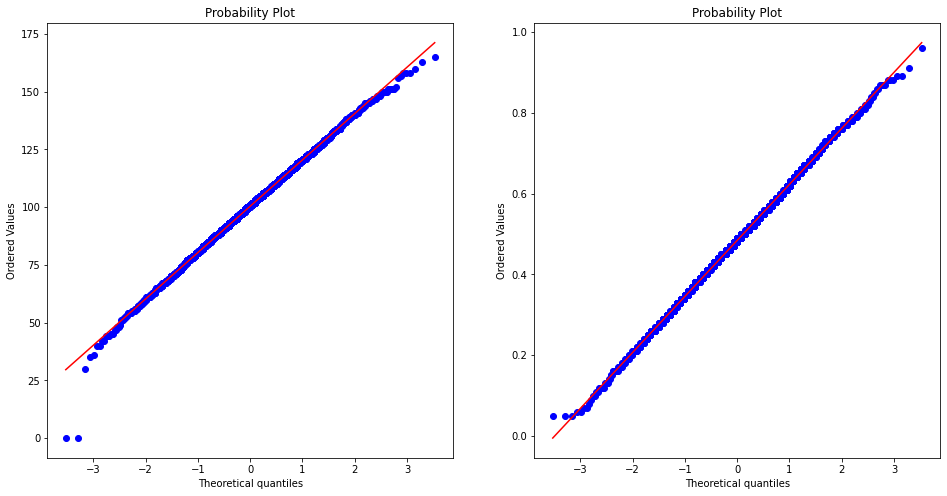

In [45]:
plt.figure(figsize=(16,8))
plt.subplot(121)
scipy.stats.probplot(data['day_calls'], dist="norm", plot = pylab)
plt.subplot(122)
scipy.stats.probplot(data['mes_estim'], dist='norm', plot=pylab)
pylab.show()

<AxesSubplot:xlabel='day_calls', ylabel='mes_estim'>

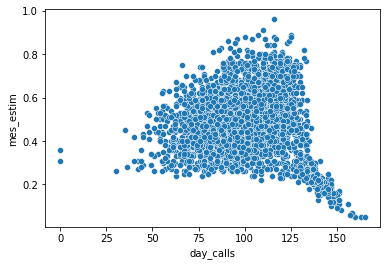

In [46]:
sns.scatterplot(x = data['day_calls'], y=data['mes_estim'])